---
title: "QuantLib, zero curves"
description: |
    A QuantLib têm diversos tipos de interpolação para estruturas a termo de taxas de juros.
    Neste post vou mostrar como utilizar a ZeroCurve.
author:
  - name: Wilson Freitas
    url: {}
date: 2023-07-26
categories:
  - python
  - quantlib
  - brasa
  - B3
---

[QuantLib]: https://www.quantlib.org/

No [post](../2023-07-19-quantlib/quantlib.ipynb) vimos a criação de uma curva de juros utilizando a classe
`ql.DiscountCurve` da QuantLib, que utiliza uma estrutura a termo dos fatores de desconto.
Aqui vamos ver como criar uma curva *zero* a partir das taxas de juros.
Nesta abordagem é possível criar curvas com outros tipos de interpolação, pois, na `DiscountCurve` a interpolação
utilizada é a linear nos logs dos fatores de desconto, que é equivalente a interpolação exponencial.
A interpolação exponencial é muito utilizada no mercado brasileiro, em particular para a curva de juros prefixados.
Neste post veremos a classe `ql.ZeroCurve` para construção de uma curva zero, que é uma curva de taxas de juros que vão
da data de referência até o vértice da curva.
Veremos também como utilizar diferentes métodos de interpolação para a curva criada.

[brasa]: https://github.com/wilsonfreitas/brasa

Vamos começar carragendo os pacotes utilizados e fazendo o setup do [brasa].

In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"
import brasa
import pyarrow.compute as pc
from datetime import datetime
import QuantLib as ql
import numpy as np
import pandas as pd
import matplotlib.ticker as mticker

Agora faremos o setup da QuantLib definindo a data de referência, que será 2023-07-14.

In [3]:
today = ql.Date().from_date(datetime(2023, 7, 14))
ql.Settings.instance().evaluationDate = today

A curva prefixada para a data de referência é carregada do dataset `b3-curves-di1` do datalake do projeto brasa.

In [4]:
curve = (brasa
         .get_dataset("b3-curves-di1")
         .filter(pc.field("refdate") == today.to_date())
         .to_table()
         .to_pandas())

Para criar uma curva zero é necessário passar um vetor com as datas dos vértices da curva e as taxas de juros da curva.
Adicionalmente, é preciso incluir um vértice referente à data de referência.
Isso é importante, caso contrário a QuantLib assume que a data de referência da curva é a data do primeiro ponto da curva
e na interpolação a contagem de dias será realizada com relação à este ponto.
A taxa definida para este vértice inicial é 0 (zero), mantendo a coerência, pois para prazo de zero dias temos zero juros,
apesar dessa definição ser redundante.

Utilizando os dias úteis e a taxa de juros da curva carregada previamente, construo os vetores de datas e taxas.

In [7]:
calendar = ql.Brazil(ql.Brazil.Settlement)
data = [(calendar.advance(today, d, ql.Days, ql.Following), r)
        for d, r in zip(curve["business_days"], curve["adjusted_tax"])]
data.insert(0, (today, 0))
dates, rates = zip(*data)

Para a criação da curva precisamos passar alguns argumentos para o construtor `ql.ZeroCurve`, que são importantes e
impactam na interpretação das taxas e interpolação da curva.
Seguem os argumentos utilizados:

- regra de contagem de dias: `ql.Business252(calendar)`
- calendário: `ql.Brazil(ql.Brazil.Settlement)`
- interpolador: `ql.Linear`
- regime de capitalização das taxas: `ql.Compounded`
- frequência das taxas: `ql.Annual`

In [8]:
zc = ql.ZeroCurve(dates, rates,
                  ql.Business252(calendar),
                  calendar,
                  ql.Linear(),
                  ql.Compounded,
                  ql.Annual)

Vamos ver algumas características interessantes da curva criada.

A curva tem um método `nodes` que retorna as datas e taxas da curva, mas atenção, as taxas retornadas são taxas 
contínuas.
Internamente a QuantLib armazena taxas contínuas, mesmo que tenham sido utilizadas taxas discretas ou simples, para
armazenamento na classe as taxas são convertidas.

In [5]:
zc.nodes()[:5]

((Date(14,7,2023), 0.12795336431048324),
 (Date(17,7,2023), 0.12795336431046694),
 (Date(1,8,2023), 0.12794507014909243),
 (Date(1,9,2023), 0.1263153339122755),
 (Date(2,10,2023), 0.12534533483937893))

In [6]:
curve.head()

,refdate,symbol,maturity_date,business_days,adjusted_tax
0,2023-07-14,CDI,2023-07-17,1,0.136500
1,2023-07-14,DI1Q23,2023-08-01,12,0.136491
2,2023-07-14,DI1U23,2023-09-01,35,0.134640
3,2023-07-14,DI1V23,2023-10-01,55,0.133540
4,2023-07-14,DI1X23,2023-11-01,76,0.132250


Como podemos observar, as taxas apresentadas em `nodes` são diferentes das taxas da tabela acima.

Agora que temos a curva criada, podemos interpolar utilizando o método `zeroRate`.

In [9]:
biz_days = calendar.businessDaysBetween(today, ql.Date(1,9,2023))
print(zc.zeroRate(biz_days/252, ql.Compounded))
print(zc.zeroRate(ql.Date(1,9,2023), ql.Business252(calendar), ql.Compounded))

13.463990 % Business/252(Brazil) Annual compounding
13.463990 % Business/252(Brazil) Annual compounding


Note que passamos o regime de capitalização, `ql.Compounded`, isso é necessário porque, a QuantLib retorna taxas
contínuas por padrão.

Abaixo segue uma função para fazer gráficos da curva que utiliza a curva criada e os pontos originais.
Isso ajuda na validação da curva.

In [10]:
def plot_curve(crv, curve):
    i_curve = pd.DataFrame({
        "days": list(range(1, curve["business_days"].max())),
        "rates": [crv.zeroRate(i/252, ql.Compounded).rate()
                for i in range(1, curve["business_days"].max())],
    })

    f_curve = pd.DataFrame({
        "days": list(range(1, curve["business_days"].max())),
        "rates": [crv.forwardRate(i/252, (i+1)/252, ql.Compounded).rate()
                for i in list(range(1, curve["business_days"].max()))],
    })

    ax = curve.plot.scatter(x="business_days", y="adjusted_tax", figsize=(12, 6),
                            label="Pontos da Curva")
    i_curve.plot(x="days", y="rates", c="red", alpha=0.5, ax=ax, label="Interpolação")
    f_curve.plot(x="days", y="rates", c="green", alpha=0.75, ax=ax, label="Forward 1D")
    ax.set_xlabel("Dias Úteis")
    ax.set_ylabel("Taxa (%)")
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1));

Abaixo temos o gráfico com os pontos da curva prefixada, a interpolação e a curva de juros a termo de 1 dia.
Como a curva foi criada com o método de interpolação linear, na curva de juros a termo isso fica evidente no formato
errático, com zigue-zagues da curva.
Para a curva prefixada, em particular, essa abordagem não faz sentido, pois sabemos que as decisões de mudança de 
juros acontece em datas específicas e as taxas a termos devem refletir isso.

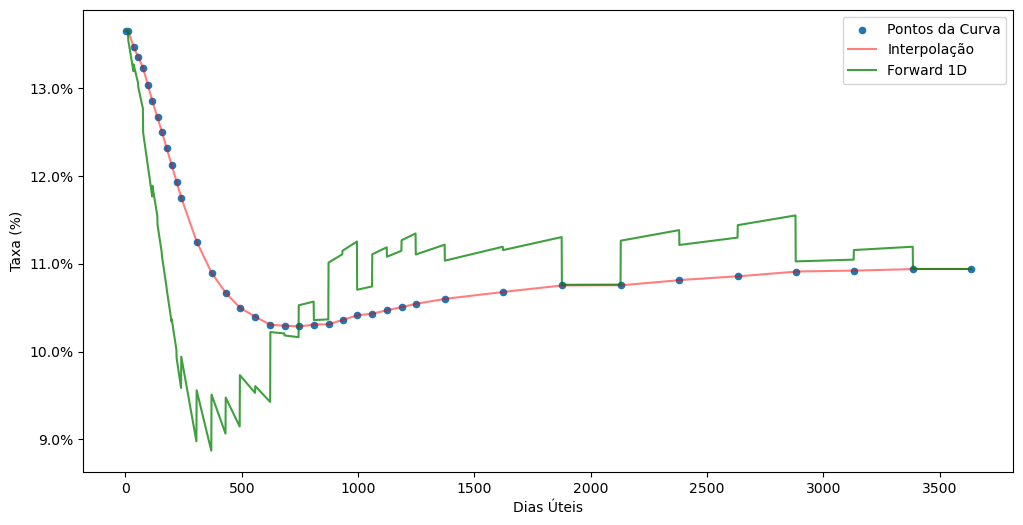

In [11]:
plot_curve(zc, curve)

A título de curiosidade, e também para explorar a QuantLib, uma nova curva zero é criada com outro método de interpolação, o cubic spline monotônico.
Abaixo temos a criação da curva e o gráfico com os pontos da curva prefixada, a interpolação e a curva de juros a termo de 1 dia.

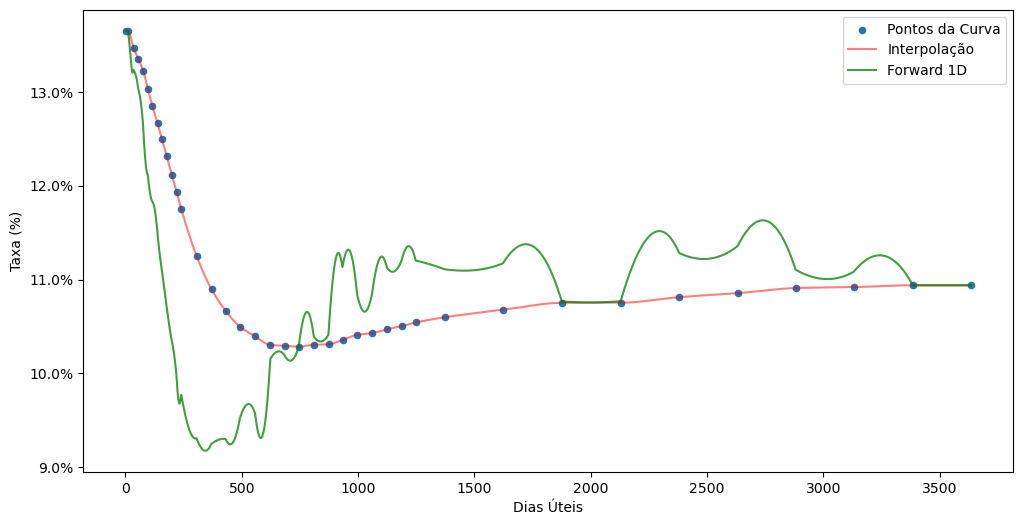

In [12]:
czc = ql.MonotonicCubicZeroCurve(dates, rates, ql.Business252(calendar), calendar,
                        ql.MonotonicCubic(), ql.Compounded, ql.Annual)
plot_curve(czc, curve)